In [1]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import SimpleITK as stk
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage import measure

In [2]:
root = 'Luna16/Dataset/'
target_root = 'Luna16/Processed/'

In [3]:
subset = 0
file_list = glob(root + f"subset{subset}/*.mhd")  # Use f-string directly
annotations_df = pd.read_csv("annotations.csv")
print("Files Count:", len(file_list))
print("DF Count:", len(annotations_df))
annotations_df.head()

Files Count: 89
DF Count: 1186


,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


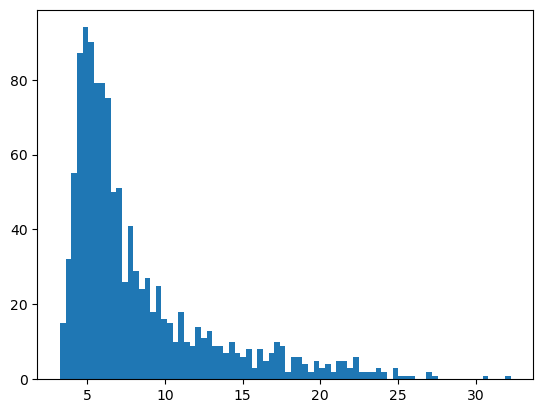

In [4]:
d = annotations_df['diameter_mm'].values
fig = plt.hist(d, bins=80)

In [5]:
def get_filename(file_list, file):
    for f in file_list:
        if file in f:
            return f

In [6]:
annotations_df["filename"] = annotations_df["seriesuid"].map(lambda file: get_filename(file_list, file))
annotations_df = annotations_df.dropna()
annotations_df = annotations_df[annotations_df['diameter_mm']>=3.9]     # Excluding nodules with diameter less than 3.9mm
print(len(annotations_df))

110


In [7]:
annotations_df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,filename
23,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.567944,67.260517,-231.816619,6.440879,Luna16/Dataset/subset0/1.3.6.1.4.1.14519.5.2.1...
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,Luna16/Dataset/subset0/1.3.6.1.4.1.14519.5.2.1...
26,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.392044,76.771663,-123.321911,4.343200,Luna16/Dataset/subset0/1.3.6.1.4.1.14519.5.2.1...
28,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.434059,117.765579,-181.947817,4.681382,Luna16/Dataset/subset0/1.3.6.1.4.1.14519.5.2.1...
86,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,145.967465,-161.197634,-312.071347,6.378436,Luna16/Dataset/subset0/1.3.6.1.4.1.14519.5.2.1...


In [8]:
def load_mhd(file):
    mhdimage = stk.ReadImage(file)
    ct_scan = stk.GetArrayFromImage(mhdimage)
    origin = np.array(list(mhdimage.GetOrigin()))
    space = np.array(list(mhdimage.GetSpacing()))
    return ct_scan, origin, space

In [9]:
def make_mask(img, center, diam):
    mask = np.zeros_like(img, dtype=np.uint8)
    
    # Calculate the center coordinates for the circle
    center_x, center_y = abs(int(center[0])), abs(int(center[1]))
    
    # Ensure that the center is within the image dimensions
    h, w = img.shape
    if 0 <= center_x < w and 0 <= center_y < h:
        mask = cv2.circle(mask, (center_x, center_y), int(abs(diam // 2)), 255, 1)
        print(f"Created mask with center: ({center_x}, {center_y}), diameter: {diam}")
        print(f"Non-zero elements in created mask: {np.count_nonzero(mask)}")
    else:
        print(f"Invalid center for mask creation: ({center_x}, {center_y}), image shape: {img.shape}")
    
    return mask

In [10]:
n_neigbours = 4

In [20]:
# Define the CLAHE filter for enhancing the contrast of an image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Iterating over all the files in the subset
for i, file in tqdm(enumerate(np.unique(annotations_df['filename'].values))):
    annotations = annotations_df[annotations_df["filename"] == file]
    ct, origin, space = load_mhd(file)  # Loading the CT scan
    num_z, height, width = ct.shape
    ct_norm = cv2.normalize(ct, None, 0, 255, cv2.NORM_MINMAX)  # Normalizing the CT scan

    # Define the number of neighboring slices to consider
    n = 3  # Number of neighboring slices to consider on each side (adjust as needed)

    # Initialize lists for neighbors with a fixed size of 2*n (for both sides)
    img_norm_neighbours = [None] * (2 * n)
    img_norm_improved_neighbours = [None] * (2 * n)
    mask_neighbours = [None] * (2 * n)

    for idx, row in annotations.iterrows():
        node_x = int(row["coordX"])  # X coordinate of the nodule
        node_y = int(row["coordY"])  # Y coordinate of the nodule
        node_z = int(row["coordZ"])  # Z coordinate of the nodule
        diam = int(row["diameter_mm"])  # Diameter of the nodule

        center = np.array([node_x, node_y, node_z])  # nodule center (x,y,z)
        v_center = np.rint((center - origin) / space)  # nodule center in voxel space (still x,y,z ordering)
        v_diam = int(diam / space[0]) + 5  # Diameter of the nodule in voxel space

        img_norm_improved = clahe.apply(im_n.astype(np.uint8))
        mask = None

        # Define the range of slices to consider around the nodule center
        min_i = max(0, int(v_center[2]) - n)
        max_i = min(num_z - 1, int(v_center[2]) + n)

        # Initialize index for assigning neighbors
        neighbour_index = 0

        # Iterating over the range of slices
        for i in range(min_i, max_i + 1):
            if i == int(v_center[2]):
                continue  # Skip the central slice as it's handled separately

            im_n = ct_norm[i, :, :]
            im_n = cv2.resize(im_n, (512, 512))
            im_n_improved = clahe.apply(im_n.astype(np.uint8))
            dia = int(2 * abs(v_center[2] - i))  # Adjust mask diameter as we move away from the center
            msk = make_mask(im_n, v_center, v_diam - dia)

            # Instead of append, we directly assign based on the current index relative to min_i
            img_norm_neighbours[neighbour_index] = im_n
            img_norm_improved_neighbours[neighbour_index] = im_n_improved
            mask_neighbours[neighbour_index] = msk
            neighbour_index += 1

            # Ensure we don't exceed the allocated size
            if neighbour_index >= len(img_norm_neighbours):
                break

        # Extract the 2D slice at the nodule's Z-index and normalize
        if len(ct.shape) == 3 and 0 <= int(v_center[2]) < num_z:
            img_slice = ct[int(v_center[2]), :, :]
            img_norm = cv2.normalize(img_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            print(f"img_norm assigned with shape: {img_norm.shape}")
        else:
            print(f"Warning: Slice index {int(v_center[2])} is out of bounds or the CT scan shape is incorrect.")
            img_norm = None

        # Check if img_norm is valid before proceeding
        if img_norm is not None and len(img_norm.shape) == 2:
            mask = make_mask(img_norm, v_center, v_diam)
            print(f"Mask created with shape: {mask.shape}")
        else:
            print("img_norm is either None or not 2D, skipping mask creation for this iteration.")
            continue

        # Proceed only if the mask is valid
        if mask is not None and mask.size > 0 and np.sum(mask) > 0:
            print("Mask before dilation is valid, proceeding with dilation.")
            # Apply dilation and other operations...
            mask = cv2.dilate(mask, kernel=np.ones((5, 5)))
            mask = cv2.bitwise_and(img_norm, img_norm, mask=mask)
        else:
            print("Warning: Mask is empty, None, or has no non-zero values. Skipping dilation.")
            continue

        # Check if img_norm is valid before proceeding
        if img_norm is None:
            print("img_norm is None. Skipping mask creation for this iteration.")
        else:
            print(f"img_norm is valid with shape: {img_norm.shape}")
        mask = make_mask(img_norm, v_center, v_diam)

        # Check if the generated mask is valid before further processing
        print(f"Mask type: {type(mask)}")
        print(f"Mask shape: {mask.shape if mask is not None else 'None'}")
        print(f"Non-zero elements in mask: {np.count_nonzero(mask) if mask is not None else 'None'}")

        # Proceed only if the mask is valid
        if mask is not None and mask.size > 0 and np.sum(mask) > 0:
            print("Mask before dilation is valid, proceeding with dilation.")
            # Apply dilation and other operations...
            mask = cv2.dilate(mask, kernel=np.ones((5, 5)))
            mask = cv2.bitwise_and(img_norm, img_norm, mask=mask)
        else:
            print("Warning: Mask is empty, None, or has no non-zero values. Skipping dilation.")

        # Extract and threshold the mask for further processing
        mask = cv2.bitwise_and(img_norm, img_norm, mask=cv2.dilate(mask, kernel=np.ones((5, 5))))
        pts = mask[mask > 0]
        kmeans2 = KMeans(n_clusters=2).fit(np.reshape(pts, (len(pts), 1)))
        centroids2 = sorted(kmeans2.cluster_centers_.flatten())
        threshold2 = np.mean(centroids2)

        _, mask = cv2.threshold(mask, threshold2, 255, cv2.THRESH_BINARY)

        if v_diam > 18:
            for i in range(neighbour_index):  # Now using the adjusted neighbour_index
                if mask_neighbours[i] is not None:  # Ensure it's not None
                    mask_neighbours[i] = cv2.bitwise_and(img_norm_neighbours[i], img_norm_neighbours[i], mask=cv2.dilate(mask_neighbours[i], kernel=np.ones((5, 5))))
                    _, mask_neighbours[i] = cv2.threshold(mask_neighbours[i], threshold2, 255, cv2.THRESH_BINARY)

        # Calculating the threshold value to segment the lungs from CT scan slices using binary thresholding
        centeral_area = img_norm[100:400, 100:400]
        kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
        centroids = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centroids)

        # Steps to segment the lungs from CT scan slices
        ret, lung_roi = cv2.threshold(img_norm, threshold, 255, cv2.THRESH_BINARY_INV)
        lung_roi = cv2.erode(lung_roi, kernel=np.ones([4, 4]))
        lung_roi = cv2.dilate(lung_roi, kernel=np.ones([13, 13]))
        lung_roi = cv2.erode(lung_roi, kernel=np.ones([8, 8]))

        labels = measure.label(lung_roi)  # Labelling different regions in the image
        regions = measure.regionprops(labels)  # Extracting the properties of the regions
        good_labels = []
        for prop in regions:  # Filtering the regions that are not too close to the edges
            B = prop.bbox  # Regions that are too close to the edges are outside regions of lungs
            if B[2] - B[0] < 475 and B[3] - B[1] < 475 and B[3] - B[1] < 475 and B[0] > 40 and B[2] < 472:
                good_labels.append(prop.label)
        lung_roi_mask = np.zeros_like(labels)
        for N in good_labels:
            lung_roi_mask = lung_roi_mask + np.where(labels == N, 1, 0)

        # Steps to get proper segmentation of the lungs without noise and holes
        contours, hierarchy = cv2.findContours(lung_roi_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        external_contours = np.zeros(lung_roi_mask.shape)
        if hierarchy is not None and len(hierarchy) > 0:
            for i in range(len(contours)):
                if len(hierarchy[0]) > i and hierarchy[0][i][3] == -1:  # External Contours
                    area = cv2.contourArea(contours[i])
                    if area>518.0:
                        cv2.drawContours(external_contours, contours, i, (1), thickness=cv2.FILLED)
        else:
            print("Warning: No hierarchy found. Ensure that contours were detected.")
    external_contours = cv2.dilate(external_contours, kernel=np.ones([4,4]))

    external_contours = cv2.bitwise_not(external_contours.astype(np.uint8))
    external_contours = cv2.erode(external_contours, kernel=np.ones((7,7)))
    external_contours = cv2.bitwise_not(external_contours)
    external_contours = cv2.dilate(external_contours, kernel=np.ones((12,12)))
    external_contours = cv2.erode(external_contours, kernel=np.ones((12,12)))

    img_norm_improved = img_norm_improved.astype(np.uint8)
    external_contours = external_contours.astype(np.uint8)      # Final segmentated lungs mask
    extracted_lungs = cv2.bitwise_and(img_norm_improved, img_norm_improved, mask=external_contours)

    mask = mask.astype(np.uint8)
    np.save(os.path.join(target_root+"nodule_mask/", f"masks_{subset}_{i}_{idx}.npy"), mask)
    np.save(os.path.join(target_root+"lungs_roi/", f"lungs_{subset}_{i}_{idx}.npy"), extracted_lungs)

    extracted_lungs_neighbours = [None]*n

    if v_diam>18:
        for i in range(n):
            img_norm_improved_neighbours[i] = img_norm_improved_neighbours[i].astype(np.uint8)
            extracted_lungs_neighbours[i] = cv2.bitwise_and(img_norm_improved_neighbours[i], img_norm_improved_neighbours[i], mask=external_contours)
            mask_neighbours[i] = mask_neighbours[i].astype(np.uint8)
            np.save(os.path.join(target_root+"nodule_mask/", f"masks_{subset}_{i}_{idx}_{i}.npy"), mask_neighbours[i])
            np.save(os.path.join(target_root+"lungs_roi/", f"lungs_{subset}_{i}_{idx}_{i}.npy"), extracted_lungs_neighbours[i])

1it [00:00,  6.97it/s]

Created mask with center: (111, 346), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (111, 346), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (111, 346), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (111, 346), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (111, 346), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (111, 346), diameter: 7
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (111, 346), diameter: 13
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (111, 346), diameter: 13
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

2it [00:00,  5.50it/s]

Created mask with center: (408, 336), diameter: 6
Non-zero elements in created mask: 16
Created mask with center: (408, 336), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (408, 336), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (408, 336), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (408, 336), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (408, 336), diameter: 6
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (408, 336), diameter: 12
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (408, 336), diameter: 12
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

3it [00:01,  2.27it/s]

Created mask with center: (427, 350), diameter: 4
Non-zero elements in created mask: 8
Created mask with center: (427, 350), diameter: 6
Non-zero elements in created mask: 16
Created mask with center: (427, 350), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (427, 350), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (427, 350), diameter: 6
Non-zero elements in created mask: 16
Created mask with center: (427, 350), diameter: 4
Non-zero elements in created mask: 8
img_norm assigned with shape: (512, 512)
Created mask with center: (427, 350), diameter: 10
Non-zero elements in created mask: 28
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (427, 350), diameter: 10
Non-zero elements in created mask: 28
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 28
Mask before dilation is valid, pr

4it [00:01,  2.74it/s]

Created mask with center: (456, 229), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (456, 229), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (456, 229), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (456, 229), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (456, 229), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (456, 229), diameter: 7
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (456, 229), diameter: 13
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (456, 229), diameter: 13
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

6it [00:02,  2.63it/s]

Created mask with center: (366, 265), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (366, 265), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (366, 265), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (366, 265), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (366, 265), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (366, 265), diameter: 8
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (366, 265), diameter: 14
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (366, 265), diameter: 14
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is val

7it [00:02,  2.51it/s]

Created mask with center: (118, 354), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (118, 354), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (118, 354), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (118, 354), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (118, 354), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (118, 354), diameter: 8
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (118, 354), diameter: 14
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (118, 354), diameter: 14
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is val

8it [00:02,  2.66it/s]

Created mask with center: (389, 269), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (389, 269), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (389, 269), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (389, 269), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (389, 269), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (389, 269), diameter: 7
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (389, 269), diameter: 13
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (389, 269), diameter: 13
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

9it [00:03,  2.98it/s]

Created mask with center: (196, 321), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (196, 321), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (196, 321), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (196, 321), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (196, 321), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (196, 321), diameter: 7
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (196, 321), diameter: 13
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (196, 321), diameter: 13
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

10it [00:03,  3.30it/s]

Created mask with center: (83, 307), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (83, 307), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (83, 307), diameter: 17
Non-zero elements in created mask: 44
Created mask with center: (83, 307), diameter: 17
Non-zero elements in created mask: 44
Created mask with center: (83, 307), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (83, 307), diameter: 13
Non-zero elements in created mask: 32
img_norm assigned with shape: (512, 512)
Created mask with center: (83, 307), diameter: 19
Non-zero elements in created mask: 48
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (83, 307), diameter: 19
Non-zero elements in created mask: 48
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 48
Mask before dilation is valid, pr

11it [00:03,  2.90it/s]

Created mask with center: (61, 318), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (61, 318), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (61, 318), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (61, 318), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (61, 318), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (61, 318), diameter: 7
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (61, 318), diameter: 13
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (61, 318), diameter: 13
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid, procee

12it [00:04,  2.19it/s]

Created mask with center: (96, 205), diameter: 14
Non-zero elements in created mask: 36
Created mask with center: (96, 205), diameter: 16
Non-zero elements in created mask: 44
Created mask with center: (96, 205), diameter: 18
Non-zero elements in created mask: 48
Created mask with center: (96, 205), diameter: 18
Non-zero elements in created mask: 48
Created mask with center: (96, 205), diameter: 16
Non-zero elements in created mask: 44
Created mask with center: (96, 205), diameter: 14
Non-zero elements in created mask: 36
img_norm assigned with shape: (512, 512)
Created mask with center: (96, 205), diameter: 20
Non-zero elements in created mask: 56
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (96, 205), diameter: 20
Non-zero elements in created mask: 56
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 56
Mask before dilation is valid, pr

13it [00:04,  2.41it/s]

Created mask with center: (113, 362), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (113, 362), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (113, 362), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (113, 362), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (113, 362), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (113, 362), diameter: 9
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (113, 362), diameter: 15
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (113, 362), diameter: 15
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is val

14it [00:05,  2.71it/s]

Created mask with center: (184, 243), diameter: 18
Non-zero elements in created mask: 48
Created mask with center: (184, 243), diameter: 20
Non-zero elements in created mask: 56
Created mask with center: (184, 243), diameter: 22
Non-zero elements in created mask: 60
Created mask with center: (184, 243), diameter: 22
Non-zero elements in created mask: 60
Created mask with center: (184, 243), diameter: 20
Non-zero elements in created mask: 56
Created mask with center: (184, 243), diameter: 18
Non-zero elements in created mask: 48
img_norm assigned with shape: (512, 512)
Created mask with center: (184, 243), diameter: 24
Non-zero elements in created mask: 64
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (184, 243), diameter: 24
Non-zero elements in created mask: 64
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 64
Mask before dilation is v

16it [00:05,  3.74it/s]

Created mask with center: (164, 358), diameter: 5
Non-zero elements in created mask: 8
Created mask with center: (164, 358), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (164, 358), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (164, 358), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (164, 358), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (164, 358), diameter: 5
Non-zero elements in created mask: 8
img_norm assigned with shape: (512, 512)
Created mask with center: (164, 358), diameter: 11
Non-zero elements in created mask: 28
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (164, 358), diameter: 11
Non-zero elements in created mask: 28
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 28
Mask before dilation is valid, pr

17it [00:05,  3.77it/s]

Created mask with center: (187, 329), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (187, 329), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (187, 329), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (187, 329), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (187, 329), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (187, 329), diameter: 11
Non-zero elements in created mask: 28
img_norm assigned with shape: (512, 512)
Created mask with center: (187, 329), diameter: 17
Non-zero elements in created mask: 44
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (187, 329), diameter: 17
Non-zero elements in created mask: 44
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 44
Mask before dilation is v

19it [00:06,  5.16it/s]

Created mask with center: (357, 323), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (357, 323), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (357, 323), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (357, 323), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (357, 323), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (357, 323), diameter: 9
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (357, 323), diameter: 15
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (357, 323), diameter: 15
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is val

20it [00:06,  3.92it/s]

Created mask with center: (317, 184), diameter: 20
Non-zero elements in created mask: 56
Created mask with center: (317, 184), diameter: 22
Non-zero elements in created mask: 60
Created mask with center: (317, 184), diameter: 24
Non-zero elements in created mask: 64
Created mask with center: (317, 184), diameter: 24
Non-zero elements in created mask: 64
Created mask with center: (317, 184), diameter: 22
Non-zero elements in created mask: 60
Created mask with center: (317, 184), diameter: 20
Non-zero elements in created mask: 56
img_norm assigned with shape: (512, 512)
Created mask with center: (317, 184), diameter: 26
Non-zero elements in created mask: 72
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (317, 184), diameter: 26
Non-zero elements in created mask: 72
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 72
Mask before dilation is v

21it [00:06,  3.46it/s]

Created mask with center: (105, 240), diameter: 3
Non-zero elements in created mask: 4
Created mask with center: (105, 240), diameter: 5
Non-zero elements in created mask: 8
Created mask with center: (105, 240), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (105, 240), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (105, 240), diameter: 5
Non-zero elements in created mask: 8
Created mask with center: (105, 240), diameter: 3
Non-zero elements in created mask: 4
img_norm assigned with shape: (512, 512)
Created mask with center: (105, 240), diameter: 9
Non-zero elements in created mask: 20
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (105, 240), diameter: 9
Non-zero elements in created mask: 20
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 20
Mask before dilation is valid, procee

22it [00:07,  3.34it/s]

Created mask with center: (142, 336), diameter: 16
Non-zero elements in created mask: 44
Created mask with center: (142, 336), diameter: 18
Non-zero elements in created mask: 48
Created mask with center: (142, 336), diameter: 20
Non-zero elements in created mask: 56
Created mask with center: (142, 336), diameter: 20
Non-zero elements in created mask: 56
Created mask with center: (142, 336), diameter: 18
Non-zero elements in created mask: 48
Created mask with center: (142, 336), diameter: 16
Non-zero elements in created mask: 44
img_norm assigned with shape: (512, 512)
Created mask with center: (142, 336), diameter: 22
Non-zero elements in created mask: 60
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (142, 336), diameter: 22
Non-zero elements in created mask: 60
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 60
Mask before dilation is v

24it [00:07,  4.41it/s]

Created mask with center: (314, 255), diameter: 23
Non-zero elements in created mask: 60
Created mask with center: (314, 255), diameter: 25
Non-zero elements in created mask: 64
Created mask with center: (314, 255), diameter: 27
Non-zero elements in created mask: 72
Created mask with center: (314, 255), diameter: 27
Non-zero elements in created mask: 72
Created mask with center: (314, 255), diameter: 25
Non-zero elements in created mask: 64
Created mask with center: (314, 255), diameter: 23
Non-zero elements in created mask: 60
img_norm assigned with shape: (512, 512)
Created mask with center: (314, 255), diameter: 29
Non-zero elements in created mask: 76
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (314, 255), diameter: 29
Non-zero elements in created mask: 76
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 76
Mask before dilation is v

25it [00:07,  3.72it/s]

Created mask with center: (60, 293), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (60, 293), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (60, 293), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (60, 293), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (60, 293), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (60, 293), diameter: 7
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (60, 293), diameter: 13
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (60, 293), diameter: 13
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid, procee

26it [00:08,  2.76it/s]

Created mask with center: (74, 264), diameter: 5
Non-zero elements in created mask: 8
Created mask with center: (74, 264), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (74, 264), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (74, 264), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (74, 264), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (74, 264), diameter: 5
Non-zero elements in created mask: 8
img_norm assigned with shape: (512, 512)
Created mask with center: (74, 264), diameter: 11
Non-zero elements in created mask: 28
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (74, 264), diameter: 11
Non-zero elements in created mask: 28
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 28
Mask before dilation is valid, proceeding

27it [00:08,  2.84it/s]

Created mask with center: (169, 216), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (169, 216), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (169, 216), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (169, 216), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (169, 216), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (169, 216), diameter: 9
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (169, 216), diameter: 15
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (169, 216), diameter: 15
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is val

28it [00:09,  3.07it/s]

Created mask with center: (285, 301), diameter: 6
Non-zero elements in created mask: 16
Created mask with center: (285, 301), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (285, 301), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (285, 301), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (285, 301), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (285, 301), diameter: 6
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (285, 301), diameter: 12
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (285, 301), diameter: 12
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

29it [00:09,  3.46it/s]

Created mask with center: (171, 357), diameter: 4
Non-zero elements in created mask: 8
Created mask with center: (171, 357), diameter: 6
Non-zero elements in created mask: 16
Created mask with center: (171, 357), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (171, 357), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (171, 357), diameter: 6
Non-zero elements in created mask: 16
Created mask with center: (171, 357), diameter: 4
Non-zero elements in created mask: 8
img_norm assigned with shape: (512, 512)
Created mask with center: (171, 357), diameter: 10
Non-zero elements in created mask: 28
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (171, 357), diameter: 10
Non-zero elements in created mask: 28
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 28
Mask before dilation is valid, pr

30it [00:09,  2.97it/s]

Created mask with center: (452, 199), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (452, 199), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (452, 199), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (452, 199), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (452, 199), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (452, 199), diameter: 9
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (452, 199), diameter: 15
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (452, 199), diameter: 15
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is val

31it [00:10,  2.53it/s]

Created mask with center: (162, 204), diameter: 5
Non-zero elements in created mask: 8
Created mask with center: (162, 204), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (162, 204), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (162, 204), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (162, 204), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (162, 204), diameter: 5
Non-zero elements in created mask: 8
img_norm assigned with shape: (512, 512)
Created mask with center: (162, 204), diameter: 11
Non-zero elements in created mask: 28
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (162, 204), diameter: 11
Non-zero elements in created mask: 28
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 28
Mask before dilation is valid, pr

32it [00:10,  2.61it/s]

Created mask with center: (105, 388), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (105, 388), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (105, 388), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (105, 388), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (105, 388), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (105, 388), diameter: 7
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (105, 388), diameter: 13
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (105, 388), diameter: 13
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

33it [00:10,  2.96it/s]

Created mask with center: (119, 230), diameter: 6
Non-zero elements in created mask: 16
Created mask with center: (119, 230), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (119, 230), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (119, 230), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (119, 230), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (119, 230), diameter: 6
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (119, 230), diameter: 12
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (119, 230), diameter: 12
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

34it [00:11,  3.29it/s]

Created mask with center: (93, 286), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (93, 286), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (93, 286), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (93, 286), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (93, 286), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (93, 286), diameter: 8
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (93, 286), diameter: 14
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (93, 286), diameter: 14
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is valid, proc

35it [00:11,  3.05it/s]

Created mask with center: (404, 319), diameter: 5
Non-zero elements in created mask: 8
Created mask with center: (404, 319), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (404, 319), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (404, 319), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (404, 319), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (404, 319), diameter: 5
Non-zero elements in created mask: 8
img_norm assigned with shape: (512, 512)
Created mask with center: (404, 319), diameter: 11
Non-zero elements in created mask: 28
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (404, 319), diameter: 11
Non-zero elements in created mask: 28
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 28
Mask before dilation is valid, pr

37it [00:11,  3.47it/s]

Created mask with center: (186, 373), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (186, 373), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (186, 373), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (186, 373), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (186, 373), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (186, 373), diameter: 7
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (186, 373), diameter: 13
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (186, 373), diameter: 13
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

38it [00:12,  4.13it/s]

Created mask with center: (353, 285), diameter: 16
Non-zero elements in created mask: 44
Created mask with center: (353, 285), diameter: 18
Non-zero elements in created mask: 48
Created mask with center: (353, 285), diameter: 20
Non-zero elements in created mask: 56
Created mask with center: (353, 285), diameter: 20
Non-zero elements in created mask: 56
Created mask with center: (353, 285), diameter: 18
Non-zero elements in created mask: 48
Created mask with center: (353, 285), diameter: 16
Non-zero elements in created mask: 44
img_norm assigned with shape: (512, 512)
Created mask with center: (353, 285), diameter: 22
Non-zero elements in created mask: 60
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (353, 285), diameter: 22
Non-zero elements in created mask: 60
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 60
Mask before dilation is v

40it [00:12,  3.88it/s]

Created mask with center: (121, 287), diameter: 17
Non-zero elements in created mask: 44
Created mask with center: (121, 287), diameter: 19
Non-zero elements in created mask: 48
Created mask with center: (121, 287), diameter: 21
Non-zero elements in created mask: 56
Created mask with center: (121, 287), diameter: 21
Non-zero elements in created mask: 56
Created mask with center: (121, 287), diameter: 19
Non-zero elements in created mask: 48
Created mask with center: (121, 287), diameter: 17
Non-zero elements in created mask: 44
img_norm assigned with shape: (512, 512)
Created mask with center: (121, 287), diameter: 23
Non-zero elements in created mask: 60
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (121, 287), diameter: 23
Non-zero elements in created mask: 60
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 60
Mask before dilation is v

42it [00:13,  3.58it/s]

Created mask with center: (129, 178), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (129, 178), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (129, 178), diameter: 17
Non-zero elements in created mask: 44
Created mask with center: (129, 178), diameter: 17
Non-zero elements in created mask: 44
Created mask with center: (129, 178), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (129, 178), diameter: 13
Non-zero elements in created mask: 32
img_norm assigned with shape: (512, 512)
Created mask with center: (129, 178), diameter: 19
Non-zero elements in created mask: 48
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (129, 178), diameter: 19
Non-zero elements in created mask: 48
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 48
Mask before dilation is v

44it [00:13,  4.27it/s]

Created mask with center: (138, 355), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (138, 355), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (138, 355), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (138, 355), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (138, 355), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (138, 355), diameter: 9
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (138, 355), diameter: 15
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (138, 355), diameter: 15
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is val

45it [00:14,  3.90it/s]

Created mask with center: (131, 355), diameter: 16
Non-zero elements in created mask: 44
Created mask with center: (131, 355), diameter: 18
Non-zero elements in created mask: 48
Created mask with center: (131, 355), diameter: 20
Non-zero elements in created mask: 56
Created mask with center: (131, 355), diameter: 20
Non-zero elements in created mask: 56
Created mask with center: (131, 355), diameter: 18
Non-zero elements in created mask: 48
Created mask with center: (131, 355), diameter: 16
Non-zero elements in created mask: 44
img_norm assigned with shape: (512, 512)
Created mask with center: (131, 355), diameter: 22
Non-zero elements in created mask: 60
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (131, 355), diameter: 22
Non-zero elements in created mask: 60
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 60
Mask before dilation is v

47it [00:14,  5.12it/s]

Created mask with center: (436, 348), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (436, 348), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (436, 348), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (436, 348), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (436, 348), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (436, 348), diameter: 7
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (436, 348), diameter: 13
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (436, 348), diameter: 13
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

48it [00:14,  4.37it/s]

Created mask with center: (115, 331), diameter: 4
Non-zero elements in created mask: 8
Created mask with center: (115, 331), diameter: 6
Non-zero elements in created mask: 16
Created mask with center: (115, 331), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (115, 331), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (115, 331), diameter: 6
Non-zero elements in created mask: 16
Created mask with center: (115, 331), diameter: 4
Non-zero elements in created mask: 8
img_norm assigned with shape: (512, 512)
Created mask with center: (115, 331), diameter: 10
Non-zero elements in created mask: 28
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (115, 331), diameter: 10
Non-zero elements in created mask: 28
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 28
Mask before dilation is valid, pr

49it [00:15,  2.02it/s]

Created mask with center: (196, 356), diameter: 17
Non-zero elements in created mask: 44
Created mask with center: (196, 356), diameter: 19
Non-zero elements in created mask: 48
Created mask with center: (196, 356), diameter: 21
Non-zero elements in created mask: 56
Created mask with center: (196, 356), diameter: 21
Non-zero elements in created mask: 56
Created mask with center: (196, 356), diameter: 19
Non-zero elements in created mask: 48
Created mask with center: (196, 356), diameter: 17
Non-zero elements in created mask: 44
img_norm assigned with shape: (512, 512)
Created mask with center: (196, 356), diameter: 23
Non-zero elements in created mask: 60
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (196, 356), diameter: 23
Non-zero elements in created mask: 60
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 60
Mask before dilation is v

50it [00:15,  2.45it/s]

Created mask with center: (337, 289), diameter: 16
Non-zero elements in created mask: 44
Created mask with center: (337, 289), diameter: 18
Non-zero elements in created mask: 48
Created mask with center: (337, 289), diameter: 20
Non-zero elements in created mask: 56
Created mask with center: (337, 289), diameter: 20
Non-zero elements in created mask: 56
Created mask with center: (337, 289), diameter: 18
Non-zero elements in created mask: 48
Created mask with center: (337, 289), diameter: 16
Non-zero elements in created mask: 44
img_norm assigned with shape: (512, 512)
Created mask with center: (337, 289), diameter: 22
Non-zero elements in created mask: 60
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (337, 289), diameter: 22
Non-zero elements in created mask: 60
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 60
Mask before dilation is v

51it [00:16,  2.87it/s]

Created mask with center: (138, 314), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (138, 314), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (138, 314), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (138, 314), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (138, 314), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (138, 314), diameter: 11
Non-zero elements in created mask: 28
img_norm assigned with shape: (512, 512)
Created mask with center: (138, 314), diameter: 17
Non-zero elements in created mask: 44
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (138, 314), diameter: 17
Non-zero elements in created mask: 44
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 44
Mask before dilation is v

52it [00:16,  2.57it/s]

Created mask with center: (412, 338), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (412, 338), diameter: 14
Non-zero elements in created mask: 36
Created mask with center: (412, 338), diameter: 16
Non-zero elements in created mask: 44
Created mask with center: (412, 338), diameter: 16
Non-zero elements in created mask: 44
Created mask with center: (412, 338), diameter: 14
Non-zero elements in created mask: 36
Created mask with center: (412, 338), diameter: 12
Non-zero elements in created mask: 32
img_norm assigned with shape: (512, 512)
Created mask with center: (412, 338), diameter: 18
Non-zero elements in created mask: 48
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (412, 338), diameter: 18
Non-zero elements in created mask: 48
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 48
Mask before dilation is v

53it [00:17,  1.91it/s]

Created mask with center: (152, 362), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (152, 362), diameter: 17
Non-zero elements in created mask: 44
Created mask with center: (152, 362), diameter: 19
Non-zero elements in created mask: 48
Created mask with center: (152, 362), diameter: 19
Non-zero elements in created mask: 48
Created mask with center: (152, 362), diameter: 17
Non-zero elements in created mask: 44
Created mask with center: (152, 362), diameter: 15
Non-zero elements in created mask: 36
img_norm assigned with shape: (512, 512)
Created mask with center: (152, 362), diameter: 21
Non-zero elements in created mask: 56
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (152, 362), diameter: 21
Non-zero elements in created mask: 56
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 56
Mask before dilation is v

54it [00:17,  2.21it/s]

Created mask with center: (420, 201), diameter: 5
Non-zero elements in created mask: 8
Created mask with center: (420, 201), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (420, 201), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (420, 201), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (420, 201), diameter: 7
Non-zero elements in created mask: 16
Created mask with center: (420, 201), diameter: 5
Non-zero elements in created mask: 8
img_norm assigned with shape: (512, 512)
Created mask with center: (420, 201), diameter: 11
Non-zero elements in created mask: 28
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (420, 201), diameter: 11
Non-zero elements in created mask: 28
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 28
Mask before dilation is valid, pr

56it [00:17,  3.50it/s]

Created mask with center: (148, 306), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (148, 306), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (148, 306), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (148, 306), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (148, 306), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (148, 306), diameter: 11
Non-zero elements in created mask: 28
img_norm assigned with shape: (512, 512)
Created mask with center: (148, 306), diameter: 17
Non-zero elements in created mask: 44
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (148, 306), diameter: 17
Non-zero elements in created mask: 44
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 44
Mask before dilation is v

57it [00:18,  3.00it/s]

Created mask with center: (84, 174), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (84, 174), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (84, 174), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (84, 174), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (84, 174), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (84, 174), diameter: 8
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (84, 174), diameter: 14
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (84, 174), diameter: 14
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is valid, proc

58it [00:19,  2.40it/s]

Created mask with center: (133, 289), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (133, 289), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (133, 289), diameter: 17
Non-zero elements in created mask: 44
Created mask with center: (133, 289), diameter: 17
Non-zero elements in created mask: 44
Created mask with center: (133, 289), diameter: 15
Non-zero elements in created mask: 36
Created mask with center: (133, 289), diameter: 13
Non-zero elements in created mask: 32
img_norm assigned with shape: (512, 512)
Created mask with center: (133, 289), diameter: 19
Non-zero elements in created mask: 48
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (133, 289), diameter: 19
Non-zero elements in created mask: 48
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 48
Mask before dilation is v

60it [00:19,  3.08it/s]

Created mask with center: (399, 336), diameter: 6
Non-zero elements in created mask: 16
Created mask with center: (399, 336), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (399, 336), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (399, 336), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (399, 336), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (399, 336), diameter: 6
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (399, 336), diameter: 12
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (399, 336), diameter: 12
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

61it [00:19,  3.87it/s]

Created mask with center: (179, 374), diameter: 19
Non-zero elements in created mask: 48
Created mask with center: (179, 374), diameter: 21
Non-zero elements in created mask: 56
Created mask with center: (179, 374), diameter: 23
Non-zero elements in created mask: 60
Created mask with center: (179, 374), diameter: 23
Non-zero elements in created mask: 60
Created mask with center: (179, 374), diameter: 21
Non-zero elements in created mask: 56
Created mask with center: (179, 374), diameter: 19
Non-zero elements in created mask: 48
img_norm assigned with shape: (512, 512)
Created mask with center: (179, 374), diameter: 25
Non-zero elements in created mask: 64
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (179, 374), diameter: 25
Non-zero elements in created mask: 64
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 64
Mask before dilation is v

62it [00:20,  3.37it/s]

Created mask with center: (175, 181), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (175, 181), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (175, 181), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (175, 181), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (175, 181), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (175, 181), diameter: 8
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (175, 181), diameter: 14
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (175, 181), diameter: 14
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is val

64it [00:20,  3.85it/s]

Created mask with center: (149, 350), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (149, 350), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (149, 350), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (149, 350), diameter: 12
Non-zero elements in created mask: 32
Created mask with center: (149, 350), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (149, 350), diameter: 8
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (149, 350), diameter: 14
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (149, 350), diameter: 14
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is val

66it [00:20,  4.87it/s]

Created mask with center: (178, 129), diameter: 6
Non-zero elements in created mask: 16
Created mask with center: (178, 129), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (178, 129), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (178, 129), diameter: 10
Non-zero elements in created mask: 28
Created mask with center: (178, 129), diameter: 8
Non-zero elements in created mask: 20
Created mask with center: (178, 129), diameter: 6
Non-zero elements in created mask: 16
img_norm assigned with shape: (512, 512)
Created mask with center: (178, 129), diameter: 12
Non-zero elements in created mask: 32
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (178, 129), diameter: 12
Non-zero elements in created mask: 32
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 32
Mask before dilation is valid

67it [00:20,  3.20it/s]

Created mask with center: (101, 302), diameter: 9
Non-zero elements in created mask: 20
Created mask with center: (101, 302), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (101, 302), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (101, 302), diameter: 13
Non-zero elements in created mask: 32
Created mask with center: (101, 302), diameter: 11
Non-zero elements in created mask: 28
Created mask with center: (101, 302), diameter: 9
Non-zero elements in created mask: 20
img_norm assigned with shape: (512, 512)
Created mask with center: (101, 302), diameter: 15
Non-zero elements in created mask: 36
Mask created with shape: (512, 512)
Mask before dilation is valid, proceeding with dilation.
img_norm is valid with shape: (512, 512)
Created mask with center: (101, 302), diameter: 15
Non-zero elements in created mask: 36
Mask type: <class 'numpy.ndarray'>
Mask shape: (512, 512)
Non-zero elements in mask: 36
Mask before dilation is val

In [27]:
ct, origin, space = load_mhd(file)  # Loading the CT scan
if ct is None or ct.size == 0:
    print(f"Warning: CT scan data for {file} is empty.")